Notebook to cluster sequences based on the hidden layer outputs of a sandstorm model

In [1]:

import tensorflow as tf
import keras as tfk
tfkl = tf.keras.layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score, ConfusionMatrixDisplay
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score,accuracy_score,recall_score,matthews_corrcoef,confusion_matrix,roc_curve, precision_recall_curve, auc
import seaborn as sns
from tfa_spectral import SpectralNormalization as SN
from sklearn.manifold import TSNE


from GA_util_custom import prototype_ppms_fast, one_hot_encode, contact_map

In [2]:
def create_SANDSTORM(seq_len=60,ppm_len=60,latent_dim=128,internal_activation='relu',output_activation='linear',output_nodes=1,output_units=1,kernel_1_size=[4,18],kernel_2_size=[4,9],kernel_3_size=[4,3]):
    # seq_len is the length of the sequences
    # Latent dim controls the number of filters
    # internal activation is a tensorflow activation function, applied to the hiden layers
    # output activation is the activation function of the model output
    # output nodes is the number of different output channels the model will have (e.g. 1 for UTR prediciton, 2 for Toehold Prediction (on, off)
    # output units is the number of units in the output layer, 1 for regression problems and N for classification with N different classes 
    
    #Define the Inputs
    input_seqs = tfk.Input(shape=(4,seq_len,1))
    input_probs = tfk.Input(shape=(ppm_len,ppm_len,1))


    # Predictive Model Definition
    #Sequence Branch
    y = SN(tfkl.Conv2D(latent_dim/4, kernel_1_size, strides=(4, 1), padding="same",activation=internal_activation))(input_seqs)
    y = tfkl.BatchNormalization()(y)
    # y = layers.SpatialDropout2D(0.2)(y)
    y = SN(tfkl.Conv2D(latent_dim/8, kernel_2_size, strides=(4, 1), padding="same",activation=internal_activation))(y)
    # y = layers.BatchNormalization()(y)
    y = SN(tfkl.Conv2D(latent_dim/16,kernel_3_size,strides=(4,1),padding='same',activation=internal_activation))(y)
    # y = layers.BatchNormalization()(y)
    y = tfkl.Flatten()(y)

    #PPM Branch    
    x = SN(tfkl.Conv2D(latent_dim/4, (9,9), strides=(ppm_len, 1), padding="same",activation=internal_activation))(input_probs)
    # x = layers.BatchNormalization()(x)
    x = tfkl.SpatialDropout2D(0.2)(x)
    x = SN(tfkl.Conv2D(latent_dim/8, (5,5), strides=(ppm_len, 1), padding="same",activation=internal_activation))(x)
    # x = layers.BatchNormalization()(x)
    x = SN(tfkl.Conv2D(latent_dim/16, (3,3),strides=(ppm_len,1),padding='same',activation=internal_activation))(x)
    x = tfkl.GlobalMaxPooling2D()(x)


    x = tfkl.Flatten()(x)

    # z = CrossAttentionLayer()([x,y])


    #Combine the two
    z = tfkl.Concatenate()([x,y])
    z = tfkl.Dense(16,activation=internal_activation)(z)
    z = tfkl.Dense(8,activation=internal_activation)(z)
    z = tfkl.Dense(4,activation=internal_activation)(z)
	
    
    output_lst = []
    for i in range(output_nodes):
        tmp = tfkl.Dense(output_units,activation=output_activation,name='prediction_output_%s'%i)(z)
        output_lst.append(tmp)


    output_model  = tfk.Model(inputs=[input_seqs,input_probs],outputs=output_lst,name='joint_model')
    return output_model

def model_plot(ground_truth,predictions):
    g = sns.jointplot(x=ground_truth,y=predictions,kind='scatter')
    g.plot_joint(sns.kdeplot, color="darkblue", zorder=1, levels=6)
    g.plot_joint(sns.regplot,scatter=False,color='black')
    plt.xlabel('Measured Function')
    plt.ylabel('Predicted Function')

In [5]:
df = pd.read_csv("../dataset/train/train_set.csv")
df.head()

,Index,Oligo_name,Unnamed: 2,Unnamed: 3,Sequence,mfe,ires_activity,promoter_activity,splicing_score,seq,s1,s2,log,label
0,23647,no_barcode;High_Priority_Viruses_Blocks;NC_012...,no_barcode,High_Priority_Viruses_Blocks,CTAGGGCGCGCCAGTCCTAGACGAGGAATTGGAATACGGGTGGAAG...,-60.8,206.29,0.000000,NaN,AGACGAGGAATTGGAATACGGGTGGAAGAAATGGGGGAAAACATTG...,206.29,206.29,7.68853,0
1,13876,no_barcode;High_Priority_Viruses_Blocks;NC_001...,no_barcode,High_Priority_Viruses_Blocks,CTAGGGCGCGCCAGTCCTTGGTGCTAGAAGGAGATAGCTGCTTGAC...,-64.3,206.29,0.006328,NaN,TGGTGCTAGAAGGAGATAGCTGCTTGACAATCATGGCAAACGACAA...,206.29,206.29,7.68853,0
2,112,no_barcode;Human_5UTR_Screen;PRSS22;NM_022119;...,no_barcode,Human_5UTR_Screen,CTAGGGCGCGCCAGTCCTACACACCCTGACCCGCATCGCCCTGGGT...,-85.9,206.29,0.000000,NaN,ACACACCCTGACCCGCATCGCCCTGGGTCTCTCGAGCCTGCTGCCT...,206.29,206.29,7.68853,0
3,2768,no_barcode;Human_5UTR_Screen;PGRMC1;NM_006667;...,no_barcode,Human_5UTR_Screen,CTAGGGCGCGCCAGTCCTCCGGCTAGTCTTTGGCCGCCGCCGAACC...,-89.4,206.29,0.000000,NaN,CCGGCTAGTCTTTGGCCGCCGCCGAACCCCGCGCGCCACTCGCTCG...,206.29,206.29,7.68853,0
4,6625,no_barcode;High_Priority_Genes_Blocks;PPARA;NM...,no_barcode,High_Priority_Genes_Blocks,CTAGGGCGCGCCAGTCCTAGATCTACAGGGACATGTACTGAGTTCC...,-61.1,206.29,0.000000,NaN,AGATCTACAGGGACATGTACTGAGTTCCTTCAGATCAGCCACACCT...,206.29,206.29,7.68853,0


In [29]:
seqs = one_hot_encode(df[['Sequence']])
print(seqs.shape)

(16674, 4, 212)


In [7]:
ppms = prototype_ppms_fast(seqs)
print(ppms.shape)

(16674, 212, 212)


In [8]:
# try different approach, train sandstorm on non-binary problem, then use binary classification later
# y = df['ires_activity']
# print(np.unique(y))

# need to convert y into binary classifications
THRESHOLD = 600
y = np.where(df['ires_activity'] >= THRESHOLD, 1, 0)
print(y[:10])
print(np.unique(y))

[0 0 0 0 0 0 0 0 0 0]
[0 1]


In [ ]:
seq_train, seq_test, ppm_train, ppm_test, y_train, y_test = train_test_split(seqs, ppms, y)

model definition

In [10]:
#parameters
LOSS = 'mse'
LR = 0.0001
EPOCHS = 300
LATENT_DIM = 64
# try larger batch sizes and latent dims (try 64)
BATCH_SIZE = 64
OUTPUT_ACT = 'sigmoid'
# INPUT_ACT = 'relu'
INTERNAL_ACT = tfkl.LeakyReLU()
ES = tfk.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='val_loss')
OPT = tfk.optimizers.Adam(learning_rate = LR)

In [11]:
sandstorm = create_SANDSTORM(seq_len=seqs.shape[2],
                                         ppm_len=ppms.shape[2],
                                         latent_dim=LATENT_DIM,
                                         internal_activation=INTERNAL_ACT,
                                         output_activation=OUTPUT_ACT,)

sandstorm.compile(optimizer=OPT,loss=LOSS,metrics='mse')
sandstorm.summary()

Model: "joint_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 212, 212, 1  0           []                               
                                )]                                                                
                                                                                                  
 spectral_normalization_3 (Spec  (None, 1, 212, 16)  1328        ['input_2[0][0]']                
 tralNormalization)                                                                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4, 212, 1)]  0           []                               
                                                                                        

In [39]:
import time

time_start = time.time()
sandstorm.fit([seq_train,ppm_train],
              y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data = [[seq_test,ppm_test],y_test],
             callbacks=ES)

print(time.time()-time_start)

Epoch 1/300
196/196 [==============================] - 16s 69ms/step - loss: 0.1185 - mse: 0.1185 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 2/300
196/196 [==============================] - 5s 26ms/step - loss: 0.0926 - mse: 0.0926 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 3/300
196/196 [==============================] - 5s 28ms/step - loss: 0.0892 - mse: 0.0892 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 4/300
196/196 [==============================] - 6s 33ms/step - loss: 0.0863 - mse: 0.0863 - val_loss: 0.0808 - val_mse: 0.0808
Epoch 5/300
196/196 [==============================] - 6s 30ms/step - loss: 0.0853 - mse: 0.0853 - val_loss: 0.0807 - val_mse: 0.0807
Epoch 6/300
196/196 [==============================] - 5s 25ms/step - loss: 0.0845 - mse: 0.0845 - val_loss: 0.0803 - val_mse: 0.0803
Epoch 7/300
196/196 [==============================] - 5s 26ms/step - loss: 0.0838 - mse: 0.0838 - val_loss: 0.0801 - val_mse: 0.0801
Epoch 8/300
196/196 [==============================] - 6s 29m

In [40]:
sandstorm.save_weights('./weights/sandstorm_binary_weights.h5')

In [21]:
y_preds = sandstorm.predict([seq_train, ppm_train])
y_preds_binary = np.where(y_preds >= 0.5, 1, 0)
y_train_binary = np.where(y_train >= 0.5, 1, 0)

391/391 [==============================] - 2s 5ms/step


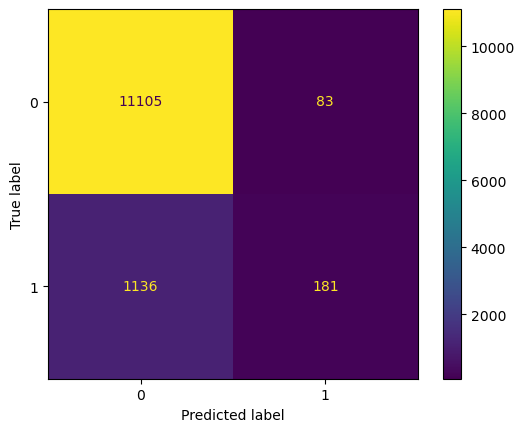

In [22]:
# confusion matrix
c_matrix = confusion_matrix(y_train_binary, y_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()

clustering based on hidden outputs

In [37]:
# function for creating intermediate model + displaying TSNE
sandstorm.load_weights('./weights/sandstorm_binary_weights.h5')
def hidden_output_tsne(layer_name, seq_train, ppm_train):
    intermediate_model = tf.keras.Model(inputs=sandstorm.input,
                                        outputs=sandstorm.get_layer(layer_name).output)
    
    hidden_outputs = intermediate_model.predict([seq_train, ppm_train])
    print(hidden_outputs.shape)
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(hidden_outputs)
    print(X_embedded.shape)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)
    plt.colorbar()
    plt.title('t-SNE Plot')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
    return X_embedded

In [40]:
# function to get subset of sequences based on TSNE plot
sequence_ndarray = np.array(df['Sequence'])
print(sequence_ndarray.shape)
def get_sequences_from_condition(condition, filename):
    print(np.unique(condition))
    print(condition.shape)
    focus_sequences = sequence_ndarray[condition]
    print(focus_sequences.shape)
    focus_activations = y[condition]
    print(focus_activations.shape)
    df = pd.DataFrame({"Sequence":focus_sequences, "active": focus_activations})
    df.head()
    df.to_csv(f"../data_subsets/sandstorm_{filename}.csv", index=False)


(16674,)


522/522 [==============================] - 5s 8ms/step
(16674, 16)
(16674, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_24504\681860168.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


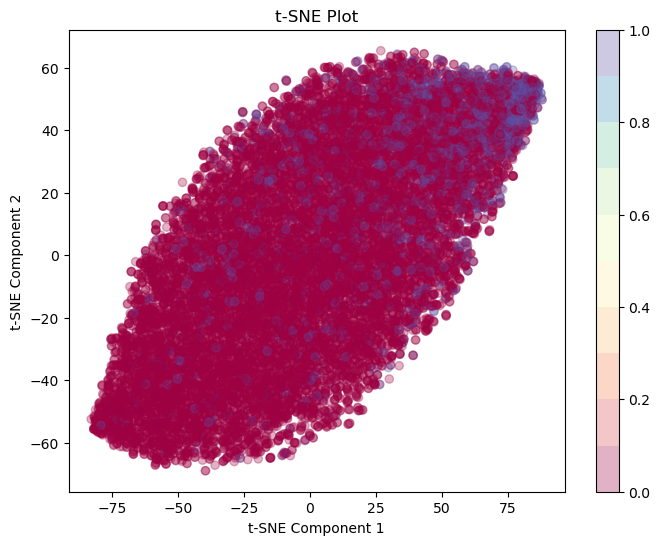

array([[-54.992928 ,  -4.7853684],
       [  3.9189057,   0.8766177],
       [ 29.811028 ,  12.381431 ],
       ...,
       [-54.50388  , -36.20948  ],
       [  2.1965792, -20.453856 ],
       [-11.960585 ,  -6.9514294]], dtype=float32)

In [45]:
# dense layer with 16 hidden outputs
hidden_output_tsne('dense', seqs, ppms)

391/391 [==============================] - 3s 7ms/step
(12505, 848)
(12505, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_90664\635183431.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


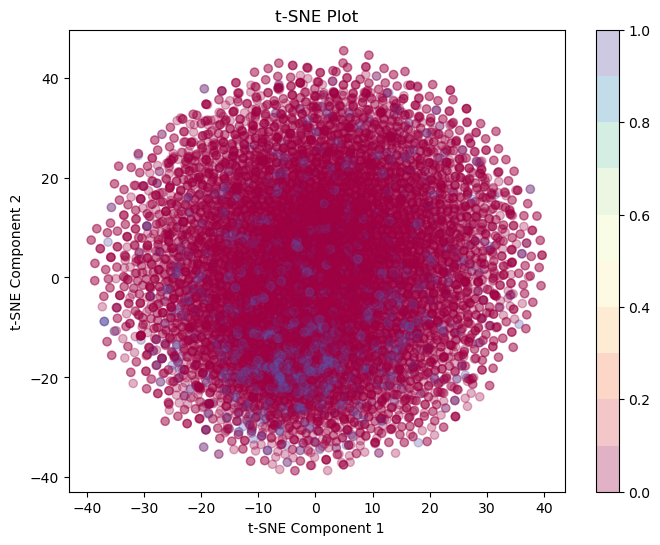

In [ ]:
# second flatten layer (848 outputs)
hidden_output_tsne('flatten', seqs, ppms)

391/391 [==============================] - 2s 3ms/step
(12505, 4)
(12505, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_90664\635183431.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


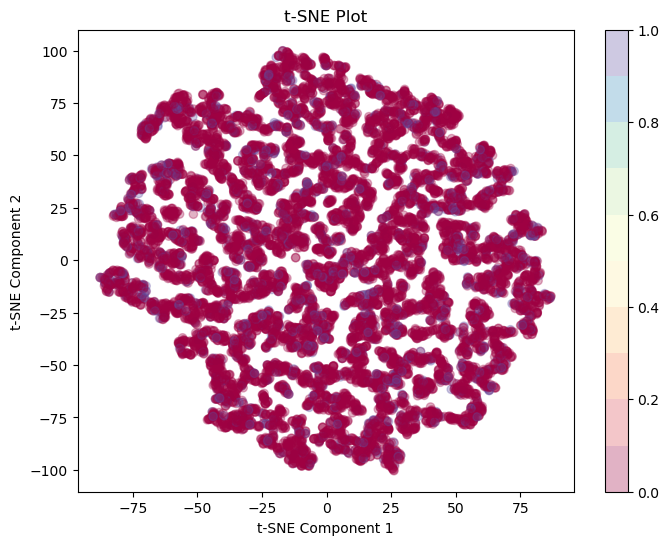

In [ ]:
# first flatten layer (4 outputs)
hidden_output_tsne('flatten_3', seqs, ppm_train)

391/391 [==============================] - 4s 8ms/step
(12505, 852)
(12505, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_90664\635183431.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


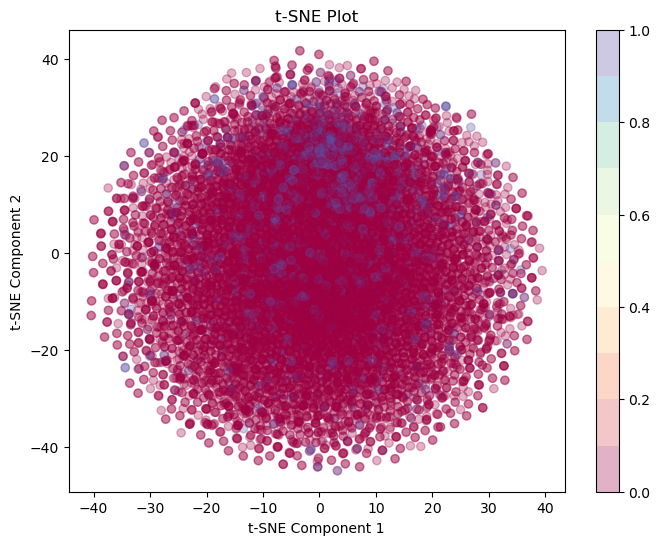

In [ ]:
# final concatenation layer (output 852)
hidden_output_tsne('concatenate', seq_train, ppm_train)

391/391 [==============================] - 3s 5ms/step
(12505, 8)
(12505, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_90664\635183431.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


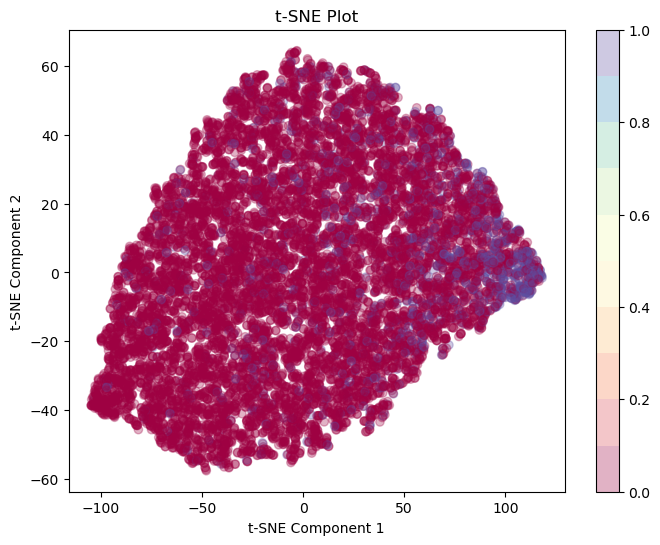

In [ ]:
# hidden dense layer with 8 outputs
hidden_output_tsne('dense_1', seq_train, ppm_train)

522/522 [==============================] - 6s 11ms/step
(16674, 4)
(16674, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_24504\681860168.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


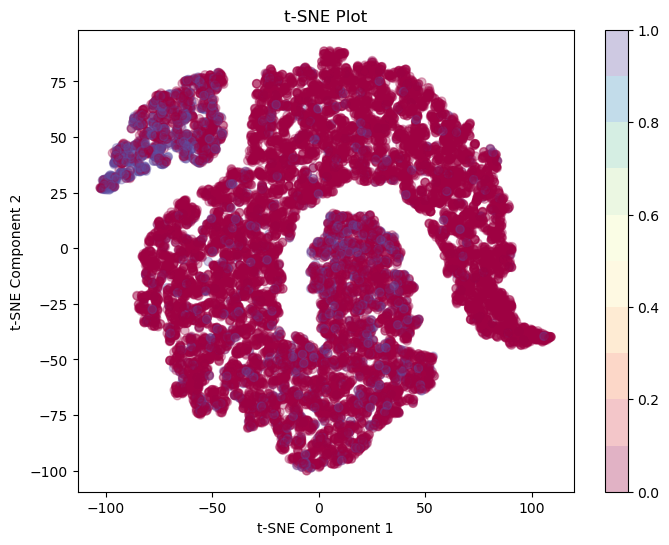

In [ ]:
# dense layer with 4 hidden outputs
X_embedded = hidden_output_tsne('dense_2', seqs, ppms)

In [42]:
condition =  ((X_embedded[:, 0] < -50) & (X_embedded[:, 1] > 25))
get_sequences_from_condition(condition, "dense_4_output")

[False  True]
(16674,)
(1384,)
(1384,)


391/391 [==============================] - 4s 8ms/step
(12505, 1)
(12505, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_90664\635183431.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


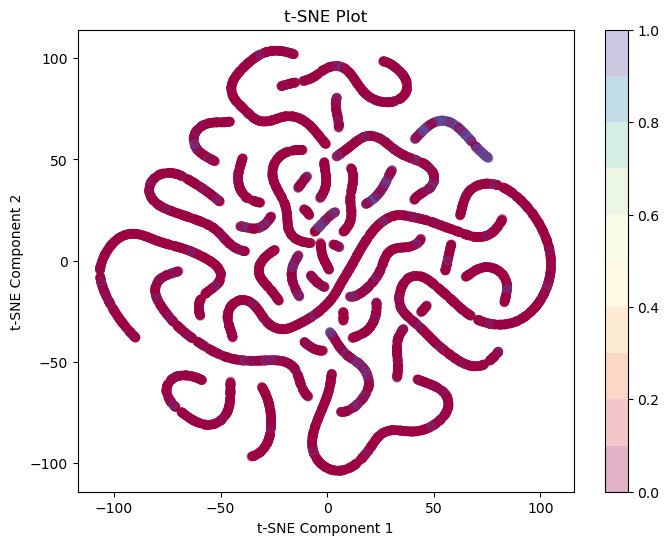

In [23]:
hidden_output_tsne('prediction_output_0', seq_train, ppm_train)

In [50]:
layer_name = 'concatenate_6'
intermediate_layer_model = tf.keras.Model(inputs=sandstorm.input,
                                          outputs=sandstorm.get_layer(layer_name).output)


In [51]:
hidden_outputs = intermediate_layer_model.predict([seq_train, ppm_train])


391/391 [==============================] - 9s 19ms/step


In [56]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(hidden_outputs)
print(X_embedded.shape)

(12505, 2)


C:\Users\jared\AppData\Local\Temp\ipykernel_69020\3899845106.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)


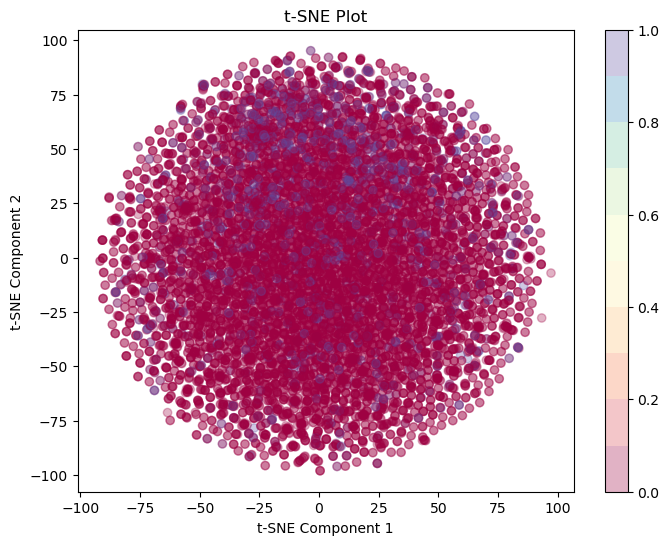

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap=plt.cm.get_cmap("Spectral", 10), alpha=0.3)
plt.colorbar()
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [47]:
# create filtering condition of zone of interest
condition = ((X_embedded[:, 0] > 40) & (X_embedded[:, 1] > 50))
# condition = X_embedded[:, 1] > 60
print(np.unique(condition))
print(condition.shape)

[False  True]
(12505,)


In [48]:
# get the sequence and activation
# focus_sequences = sequence_ndarray[condition]
focus_activations = y_train[condition]
# print(focus_sequences.shape)
# print(focus_sequences[:10])
print(focus_activations.shape)
print(focus_activations[:10])

(842,)
[1 1 1 0 0 0 1 0 0 0]
